**图像的背景噪声估计**  
@Author: Ray  
@Time: 2022.09.19  
@Cite: [photutils.background](https://photutils.readthedocs.io/en/stable/background.html)

> 图像的背景噪声
* 背景噪声来源于sky和detector
* 对源检测和估计测光误差很重要
* 计算背景的目标是给出背景的mean, median, std等统计量
* 计算背景的关键在于如何去除sources的干扰

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import SqrtStretch, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize

---
## 恒定背景噪声
* 恒定背景(scalar background)是指图像的背景噪声不随CCD的空间分布而变化，是一种简化的情况
* 文档里给出计算恒定背景噪声的两种方法：
    1. sigma clipping: 通过迭代排除n个sigma(n是自己设定的参数)之外的数据(也就是属于源的像素值)，收敛后即为背景
    2. mask法: 将源mask掉，然后计算背景

median: 5.225529518399048
biweight: 5.186759755495727
median absolute deviation: 2.1443760096598914


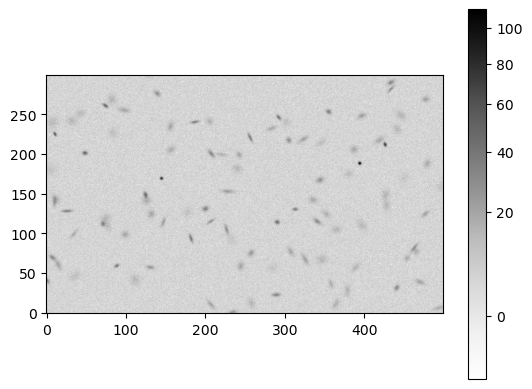

In [3]:
# 生成实验图像（包含100个源，添加一个高斯背景，中值为5，标准差是2）
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image(noise=True)

norm = ImageNormalize(interval=MinMaxInterval(), stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower', cmap='Greys')
plt.colorbar()

from astropy.stats import biweight_location, mad_std
print(f"median: {np.median(data)}")
print(f"biweight: {biweight_location(data)}")
print(f"median absolute deviation: {mad_std(data)}")

### sigma截断法 ([Sigma Clipping](https://docs.astropy.org/en/stable/api/astropy.stats.SigmaClip.html?highlight=SigmaClip))
* sigma clipping：移除图像上的源(n倍sigma之外的值)，然后再做图像统计（计算移除源之后的图像mean, median, std）
* 该算法可以很好地估计背景噪声

In [4]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(data=data, sigma=3.0)
print(mean, median, std)

5.1991386516217695 5.155587433358291 2.09427521213297


### Mask后再截断 ([Masking Sources](https://photutils.readthedocs.io/en/stable/background.html#masking-sources))

In [5]:
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

# 计算源检测的阈值
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)

# 使用detect_sources函数构建segmetation-image
segment_img = detect_sources(data, threshold, npixels=10)

# 将源mask掉
footprint = circular_footprint(radius=10)
mask = segment_img.make_source_mask(footprint=footprint)

# mask后，重新计算图像的统计参数
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
print((mean, median, std))

(4.994042038715669, 4.991333562774164, 1.9699473426119296)


---
## 2D背景噪声
* 2D背景噪声的处理思想是：
    1. 划分网格，假设每个网格的噪声二维分布是近似均匀的。
    2. 每个网格执行恒定背景噪声估计。这样就获得了一个低分辨率的背景图像。
    3. 对低分辨率的背景图像进行内插，得到最终的背景图像

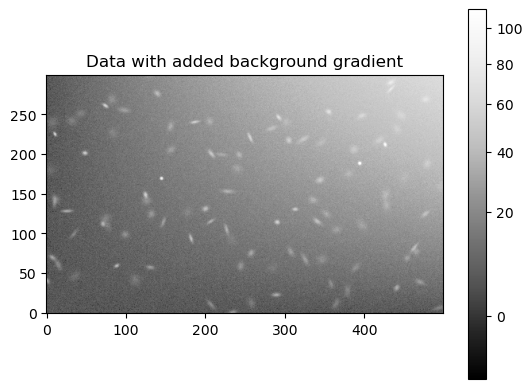

In [12]:
# 创建实验图像：在上个图像的基础上添加一个噪声变化
ny, nx = data.shape
y, x = np.mgrid[:ny, :nx]
gradient = x * y / 5000.
data = data + gradient
plt.imshow(data, norm=norm, origin='lower', cmap='Greys_r') 
plt.title("Data with added background gradient")
plt.colorbar()

### 使用[Background2D](https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D)估计2D背景和背景噪声

重要参数：
1. `box_size`: 网格块的尺寸(ny, nx)。
    * 该尺寸需要比源的典型尺寸大，但是还要足够小，使同一个网格块内背景的变化足够小
    * 图像两个方向的尺寸应该是网格块的整数倍，以充分利用数据。如果不是，需要用`edge_method`辅助
2. `bkg_estimator`: 每个网格块估计背景的算法（类）  
    提供的算法：
    * [MeanBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MeanBackground.html#photutils.background.MeanBackground)
    * [MedianBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MedianBackground.html#photutils.background.MedianBackground)
    * [ModeEstimatorBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.ModeEstimatorBackground.html#photutils.background.ModeEstimatorBackground)
    * [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground)
    * [SExtractorBackground(default)](https://photutils.readthedocs.io/en/stable/api/photutils.background.SExtractorBackground.html#photutils.background.SExtractorBackground)
    * [BiweightLocationBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.BiweightLocationBackground.html#photutils.background.BiweightLocationBackground)
3. `bkgrms_estimator`: 每个网格块估计背景均方根(RMS)的算法（类）
    * [StdBackgroundRMS](https://photutils.readthedocs.io/en/stable/api/photutils.background.StdBackgroundRMS.html#photutils.background.StdBackgroundRMS)
    * [MADStdBackgroundRMS](https://photutils.readthedocs.io/en/stable/api/photutils.background.MADStdBackgroundRMS.html#photutils.background.MADStdBackgroundRMS)
    * [BiweightScaleBackgroundRMS](https://photutils.readthedocs.io/en/stable/api/photutils.background.BiweightScaleBackgroundRMS.html#photutils.background.BiweightScaleBackgroundRMS)
4. `sigma_clip`: 默认和大多数单网格块背景估计算法使用sigma截断算法，因此需要输入`SigmaClip(sigma=3.0)类`
5. `filter_size`: 中值滤波器大小。每个网格块的背景估计完后，需要用滤波器平滑（有可能某个网格块受亮星系影响很大，平滑以减轻影响）; 可设置`filter_threshold`参数，只有背景等级高于这个阈值的网格块才会被中值滤波
6. `interpolator`: 内插器。将低分辨率的背景通过内插值提高分辨率。默认使用[BkgZoomInterpolator](https://photutils.readthedocs.io/en/stable/api/photutils.background.BkgZoomInterpolator.html#photutils.background.BkgZoomInterpolator)，另外还可以选择[BkgIDWInterpolator](https://photutils.readthedocs.io/en/stable/api/photutils.background.BkgIDWInterpolator.html#photutils.background.BkgIDWInterpolator)

In [25]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

bkg = Background2D(
    data=data, # 原始图像
    box_size=(50, 50), # 网格尺寸
    sigma_clip=SigmaClip(sigma=3.0), # 每个网格内使用sigma截断算法计算背景
    bkg_estimator=MedianBackground(),  # 每个网格选用的背景等级估计算法
    filter_size=(3, 3) # 中值滤波器大小，用于平滑异常估计值
    )

### bkg类的一些属性

background image

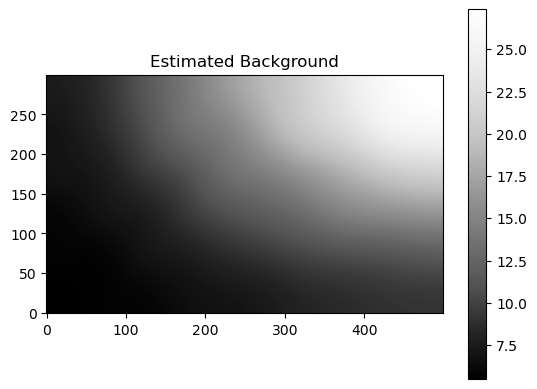

In [13]:
# background image
plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
plt.title("Estimated Background")
plt.colorbar()

background RMS image

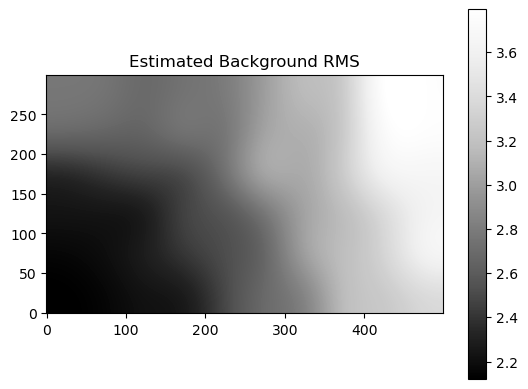

In [29]:
# background RMS image
plt.imshow(bkg.background_rms, origin='lower', cmap='Greys_r')
plt.title("Estimated Background RMS")
plt.colorbar()

中间值

In [27]:
print(bkg.background_median)  # 背景噪声的中间值
print(bkg.background_rms_median)  # 背景RMS的中间值

16.425338815314873
2.7728832784449287


background mesh image

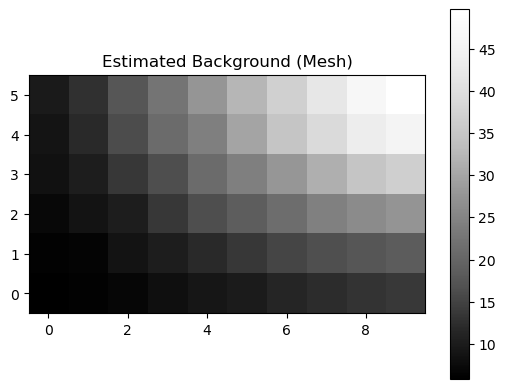

In [32]:
# background_mesh image
plt.imshow(bkg.background_mesh, origin='lower', cmap='Greys_r')
plt.title("Estimated Background (Mesh)")
plt.colorbar()

background RMS mesh image

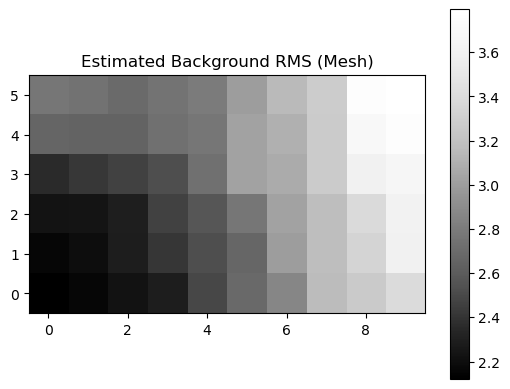

In [34]:
# background RMS mesh image
plt.imshow(bkg.background_rms_mesh, origin='lower', cmap='Greys_r')
plt.title("Estimated Background RMS (Mesh)")
plt.colorbar()

### 扣除背景的图像

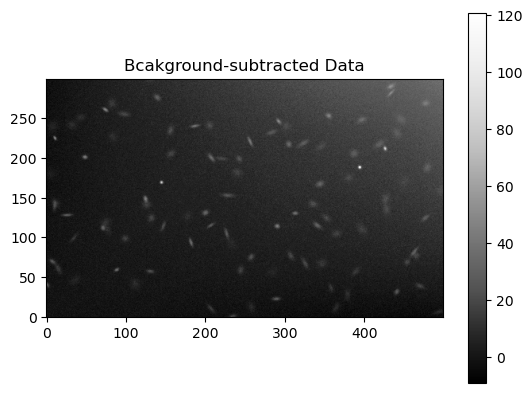

In [15]:
# show bkg-subtracted image
plt.imshow(data-bkg.background, origin='lower', cmap='Greys_r')
plt.title("Bcakground-subtracted Data")
plt.colorbar()

### 在原始图像中画出网格

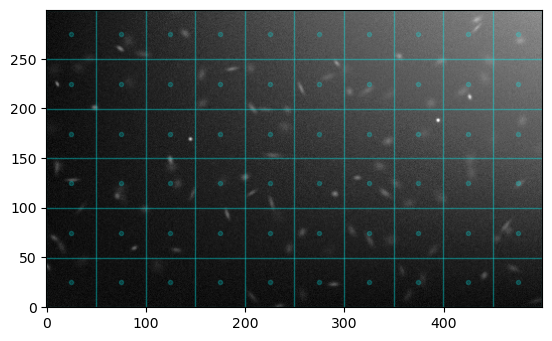

In [20]:
# plotting meshes
plt.imshow(data, origin='lower', cmap='Greys_r')
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.2)

---
## Background2D的mask参数  
`Background2D`提供了2个做mask的参数, 以便在估计背景之前排出掉这些像素：
1. `mask`: mask sources or bad pixels  
2. `coverage_mask`: mask掉图像中的非数据部分。`fill_value`参数可指定这部分数据

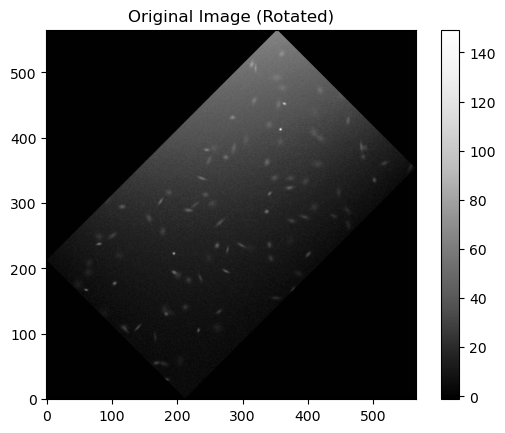

In [42]:
# 创建实验图像
from scipy.ndimage import rotate

data_roatate = rotate(data, -45.)
plt.imshow(data_roatate, origin='lower', cmap='Greys_r')
plt.title("Original Image (Rotated)")
plt.colorbar()

In [46]:
# 将无效区域（特征是像素值为0）mask掉
coverage_mask = (data_roatate == 0)

bkg = Background2D(
    data=data_roatate, 
    box_size=(15, 15), 
    filter_size=(3, 3), 
    coverage_mask=coverage_mask, # 无效区域的mask
    fill_value=0.0, 
    exclude_percentile=50.
    )

background image

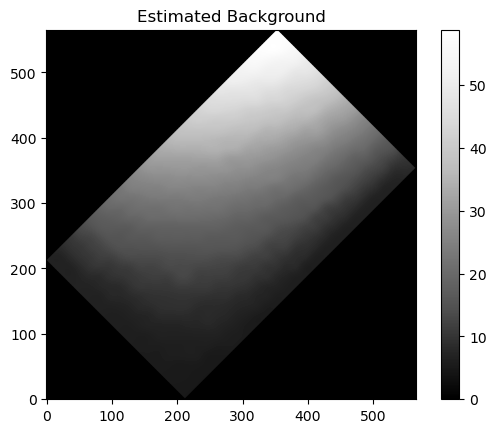

In [49]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
plt.title("Estimated Background")
plt.colorbar()

扣除背景后的图像

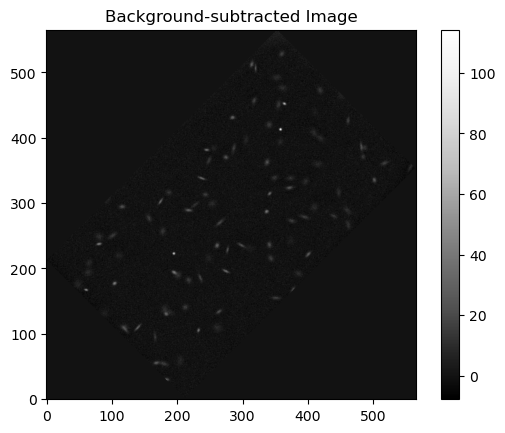

In [50]:
plt.imshow(data_roatate - bkg.background, origin='lower', cmap='Greys_r')
plt.title("Background-subtracted Image")
plt.colorbar()

### 在原始图像中画出网格

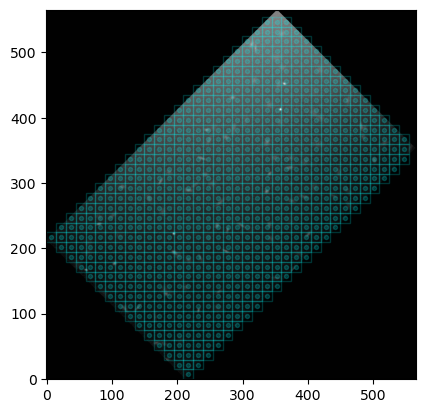

In [51]:
# plotting meshes
plt.imshow(data_roatate, origin='lower', cmap='Greys_r')
bkg.plot_meshes(outlines=True, marker='.', color='cyan', alpha=0.2)